# Reinforcement Learning || Q Learning || Off Policy Method || Value Based

Hola Folks, (or myself from the future mostly).
<br>
This notebook consists of some important RL based algorithm, that I wanted to try building myself rather than using a library imports. 

Throughout this notebook, I'll also add context of each step to make it accessible and easy to navigate for somehow who is directly jumping to RL as a beginner and doesn't have a lot of background. This ofcourse it to help me get a good refresher in the future to jog my memory incase I ever want to.

## What is RL?

RL is an extension to Artificial intelligence and a field which tried to derive knowledge from human interaction. Essentially, we have an *agent* that we control and teach to make decisions by interacting with the *envrionment*.  These interaction happen through various *action* and result in changing of the *states*. Good actions that lead to something meaningful are *rewarded* positively while the orther actions are rewarded negatively. 

Different iteration of different *episodes* help build various *trajectories* and this in turn helps the agent to come up with a *policy* (or strategy) that determines the next actions.

**GOAL** of the RL is to train agents such that the actions it takes results in maximum cumulative rewards.

## How to Solve RL?

Three main/popular ways of solving an RL problem is: 
1. Policy gradient method
2. Policy Gradient Method, with Value function
3. Only Value function (value Functions and Action Value (Q) functions)

In Policy methods, we adjust the probabilities of different actions that can be taken from a state, while in Value based methods we train the agent to understand how good/bad a particular state is.

There are some concepts to have a good background in which I will not be mentioning in depth here like:
1. Deterministic State/Actions vs Continuos State/Actions
2. Model Based vs Model Free Based
3. Improvement vs Evaluation
4. Monte Carlo Method
5. Markov Decision Processes

## Q Learning

Q learning is a model-free RL algorithm to find an optimal action value (Q) function for a *finite* Markov Decision process (MDP).

- Q here stands for Quality
- This is an off Policiy method because the behavious policy and the target policy is not the same.

### Other Core Concepts

1. **Value Based Learning**:  Developing a Q value and Q Table.
2. **Exploration vs Exploitation**: We will use *epsilon* to make that tradeoff.

## Q Learning Code project - Solving a maze

This is a typical example that is shown in most of the tutorials online, where you have a starting state and the goal is to reach the end, which is a speicified position in the maze. In a model based environment, this would be easier as we'd have access to all the state - action - reward pairs but since it's a model free RL mechanism, we have to build learn using experience (or iterative improvment).

In the end, We will end up with a *Q-Table* that will store all the *Q-values*. learned through the training. In the end, we will use the Q-Table for look-up. Q-value for a given state and action pair determines how good or bad a taking a certain action is for that state.

We wll use a 4x4 gird example, with some obstacles for our maze solver. (I used to be a designer, and I made the below on an excel sheet. Fogive me lords!)

<p align="center">
    <img src="media/4x4_maze.png" alt="4x4 Maze" width="300"/>
</p>


### Environment Setup

We will use x,y co-ordinates on our grid for navigation

In [84]:
import numpy as np 
import random 

GRID_SIZE = 4
START = (3,0)
GOAL = (3,3)

OBSTACLES = [(2, 1), (2, 2), (3,2)]

#Actions:
ACTIONS = { # Row, Column
    'UP': (-1, 0),
    'DOWN': (1, 0),
    'LEFT': (0, -1),
    'RIGHT': (0, 1)
}

In [85]:
def is_valid_state(state: tuple[int, int]) -> bool:
    x, y = state
    if 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in OBSTACLES:
        return True
    return False


def generate_next_state(state: tuple[int, int], action: str) -> tuple[int, int]:
    x, y = state
    if action not in ACTIONS:
        raise ValueError(f"Invalid action: {action}")

    next_state = (x + ACTIONS[action][0], y + ACTIONS[action][1])

    return next_state if is_valid_state(next_state) else state

### Q Learning Parameters

1. **EPSILON (e)**: This sets the exploration rate. For instance, an epsilon value of 0.2 would mean that the model choses a random action 20% of the time. You adjust the value of epsilon with number of episodes.
2. **ALPHA**: This is the learning rate. It tell the agent how much to value the new infomration. A value of 0.7 would mean that it retains 70% of the old information
3. **GAMMA**: Discount factor for the rewards. Determines how the future rewards are valued. A value close to one would mean that the agent care about future reward and current reward equally. This lets us decide between current reward vs delayed rewards.
4. **EPISODES**: Total number of training episodes

### Reward function

We will reward 100 points for reaching the goal, -10 for hitting the wall or the obstacles and -1 for any other step. (This will motivate the model to try and reach the goal marker for maximum reward)

In [86]:
def reward_function(state: tuple[int,int], next_state: tuple[int, int]) -> int:
    if next_state == GOAL:
        return 100  # Take the reward and go to the goal
    elif next_state in OBSTACLES or next_state == state: # If the state didn't change, it means that it hit the boundary.
        return -10  
    return -1 

### Choosing an action

We will use Q_table which will be a dictionary, in the formart *{state: {action: q_value}}*

In [87]:
def choose_action(state: tuple[int, int], q_table: dict) -> str:
    if random.uniform(0, 1) < EPSILON:
        return random.choice(list(ACTIONS))
    else:
        states_q_values = q_table.get(state, {})
        if states_q_values:
            return max(states_q_values, key=states_q_values.get)
        return random.choice(list(ACTIONS))

### Improving the Q-Table.

We will improve the Q-Table by updating the Q-Values inside it. This can be done using bellman equation.

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

Note: Here we are using *$ \max_{a'} Q(s',a')$*, 

1. **SARSA:** If instead we used the trajectory to find what actual action was taken and use *$ Q(s',a') $*, it'll be termed as **SARSA**.
2. **Expected SARSA:** If instead we averaged over all the action possibilities and used that, i.e.,   *$ \sum_{a'} \pi(a'|s') Q(s', a')$*    it'll be termed as **Expected SARSA**.

**NOTE:** SARSA and Expected SARSA is on policy methods while Q-Learning is a Off-Policy method.

In [88]:
ALPHA = 0.2 # Learning rate
EPSILON = 0.3 # Exploration rate
GAMMA = 0.9 # Discount factor
EPISODES = 100 # Number of episodes to train

In [89]:
def update_q_table(q_table: dict, state: tuple[int, int], action: str, reward: int, next_state: tuple[int, int]) -> None:
    q_table.setdefault(state, {}) # Initialize the state in the Q-table if not present

    # Step 1: Action value for the current state-action pair
    current_q = q_table[state].get(action, 0.0)

    # Step 2:  Maximum action value for the next state
    next_q = max(q_table.get(next_state, {}).values(), default=0.0)
    
    #Step 3: Update the Q-value using the Q-learning formula
    q_table[state][action] = current_q + ALPHA * (reward + GAMMA * next_q - current_q)

### Train with episodes

After training, We should get the knowledgeble Q-Table.

We will start by initializing the Q-Table of correct size. Initialize the current state as the start state and then use a loop to conitnue further steps until the goal is reached. These steps will involve choosing an action, determining the next state based on the action, calculate the reward, update the Q-Table for that state-action pair based on the reward and next state. Finally move to the next state and continue doing the same till you reach the goal.

Ideally, after all the episodes, Q-Table should return the best moves to make for reaching the goal.

In [90]:
def train_agent() -> dict:
    q_table = {}
    
    for episode in range(EPISODES):
        state = START
        while state != GOAL:
            action = choose_action(state, q_table)
            next_state = generate_next_state(state, action)
            reward = reward_function(state, next_state)
            update_q_table(q_table, state, action, reward, next_state)
            state = next_state

    return q_table

In [91]:
q_table = train_agent()

In [92]:
# def visualize_q_table_as_grid(q_table: dict) -> None:
#     """Visualize the Q-table as a grid with all action values for each state."""
#     action_names = ['UP', 'RIGHT', 'DOWN', 'LEFT']
#     action_symbols = ['^', '>', 'v', '<']
    
#     print("\nDetailed Q-table Grid:")
    
#     # Header
#     header = "   |" + "|".join(f"   ({i},{j})   " for j in range(GRID_SIZE) for i in range(GRID_SIZE)) + "|"
#     print(header)
#     print("-" * len(header))

#     for action_idx, (action_name, action_symbol) in enumerate(zip(action_names, action_symbols)):
#         row = f" {action_symbol} |"
#         for i in range(GRID_SIZE):
#             for j in range(GRID_SIZE):
#                 if (i, j) == GOAL:
#                     cell = "   GOAL    "
#                 elif (i, j) in OBSTACLES:
#                     cell = " OBSTACLE  "
#                 else:
#                     q_value = q_table.get((i, j), {}).get(action_name, 0.0)
#                     cell = f" {q_value:9.2f} "
#                 row += cell + "|"
#         print(row)
#         print("-" * len(header))

# def visualize_best_actions_grid(q_table: dict) -> None:
#     """Visualize the best action and its Q-value for each state in a grid."""
#     action_names = ['UP', 'RIGHT', 'DOWN', 'LEFT']
#     action_symbols = ['^', '>', 'v', '<']
    
#     print("\nBest Actions Grid:")
#     header = "-" * (14 * GRID_SIZE + 1)
#     print(header)

#     for i in range(GRID_SIZE):
#         row = "| "
#         for j in range(GRID_SIZE):
#             if (i, j) == GOAL:
#                 cell = "   GOAL    "
#             elif (i, j) in OBSTACLES:
#                 cell = " OBSTACLE  "
#             else:
#                 state_q_values = q_table.get((i, j), {})
#                 if state_q_values:
#                     best_action = max(state_q_values, key=state_q_values.get)
#                     best_q_value = state_q_values[best_action]
#                     best_symbol = action_symbols[action_names.index(best_action)]
#                     cell = f"{best_symbol}:{best_q_value:7.2f}  "
#                 else:
#                     cell = "  N/A     "
#             row += cell + " | "
#         print(row)
#         print(header)

#### I just asked ChatGPT to make the above code better hehe. I'm Lazy but smart.

In [93]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_q_table_as_grid(q_table: dict) -> None:
    """Visualize the Q-table as a grid with all action values for each state using matplotlib."""
    fig, axes = plt.subplots(GRID_SIZE, GRID_SIZE, figsize=(2*GRID_SIZE, 2*GRID_SIZE))
    action_names = list(ACTIONS.keys())
    action_symbols = {'UP': '^', 'DOWN': 'v', 'LEFT': '<', 'RIGHT': '>'}
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            ax = axes[i, j]
            ax.set_xticks([])
            ax.set_yticks([])
            state = (i, j)
            ax.set_facecolor('white')
            if state == GOAL:
                ax.set_facecolor('#b6e3b6')
                ax.text(0.5, 0.5, "GOAL", ha='center', va='center', fontsize=14, fontweight='bold')
            elif state in OBSTACLES:
                ax.set_facecolor('#e3b6b6')
                ax.text(0.5, 0.5, "OBSTACLE", ha='center', va='center', fontsize=10, fontweight='bold')
            else:
                q_vals = q_table.get(state, {})
                # Draw arrows and values for each action
                for action, (dx, dy) in ACTIONS.items():
                    q = q_vals.get(action, 0.0)
                    if action == 'UP':
                        ax.annotate(f"{q:.1f}", (0.5, 0.85), ha='center', va='center', color='blue', fontsize=10)
                        ax.annotate(action_symbols[action], (0.5, 0.95), ha='center', va='center', color='blue', fontsize=12)
                    elif action == 'DOWN':
                        ax.annotate(f"{q:.1f}", (0.5, 0.15), ha='center', va='center', color='green', fontsize=10)
                        ax.annotate(action_symbols[action], (0.5, 0.05), ha='center', va='center', color='green', fontsize=12)
                    elif action == 'LEFT':
                        ax.annotate(f"{q:.1f}", (0.15, 0.5), ha='center', va='center', color='purple', fontsize=10)
                        ax.annotate(action_symbols[action], (0.05, 0.5), ha='center', va='center', color='purple', fontsize=12)
                    elif action == 'RIGHT':
                        ax.annotate(f"{q:.1f}", (0.85, 0.5), ha='center', va='center', color='orange', fontsize=10)
                        ax.annotate(action_symbols[action], (0.95, 0.5), ha='center', va='center', color='orange', fontsize=12)
            ax.set_title(f"({i},{j})", fontsize=10)
    plt.suptitle("Q-table Visualization (All Actions)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def visualize_best_actions_grid(q_table: dict) -> None:
    """Visualize the best action and its Q-value for each state in a grid using matplotlib."""
    fig, ax = plt.subplots(figsize=(1.5*GRID_SIZE, 1.5*GRID_SIZE))
    ax.set_xlim(-0.5, GRID_SIZE-0.5)
    ax.set_ylim(-0.5, GRID_SIZE-0.5)
    ax.set_xticks(np.arange(-0.5, GRID_SIZE, 1))
    ax.set_yticks(np.arange(-0.5, GRID_SIZE, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True, which='both', color='black', linewidth=1)
    action_symbols = {'UP': '^', 'DOWN': 'v', 'LEFT': '<', 'RIGHT': '>'}
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            state = (i, j)
            if state == GOAL:
                ax.add_patch(plt.Rectangle((j-0.5, GRID_SIZE-1-i-0.5), 1, 1, color='#b6e3b6'))
                ax.text(j, GRID_SIZE-1-i, "GOAL", ha='center', va='center', fontsize=14, fontweight='bold')
            elif state in OBSTACLES:
                ax.add_patch(plt.Rectangle((j-0.5, GRID_SIZE-1-i-0.5), 1, 1, color='#e3b6b6'))
                ax.text(j, GRID_SIZE-1-i, "OBSTACLE", ha='center', va='center', fontsize=10, fontweight='bold')
            else:
                state_q_values = q_table.get(state, {})
                if state_q_values:
                    best_action = max(state_q_values, key=state_q_values.get)
                    best_q_value = state_q_values[best_action]
                    symbol = action_symbols[best_action]
                    ax.text(j, GRID_SIZE-1-i+0.15, symbol, ha='center', va='center', fontsize=22, color='black')
                    ax.text(j, GRID_SIZE-1-i-0.18, f"{best_q_value:.1f}", ha='center', va='center', fontsize=10, color='blue')
                else:
                    ax.text(j, GRID_SIZE-1-i, "N/A", ha='center', va='center', fontsize=10, color='gray')
            ax.text(j, GRID_SIZE-1-i-0.38, f"({i},{j})", ha='center', va='center', fontsize=8, color='gray')
    plt.title("Best Action per State (Q-table)", fontsize=16)
    plt.show()

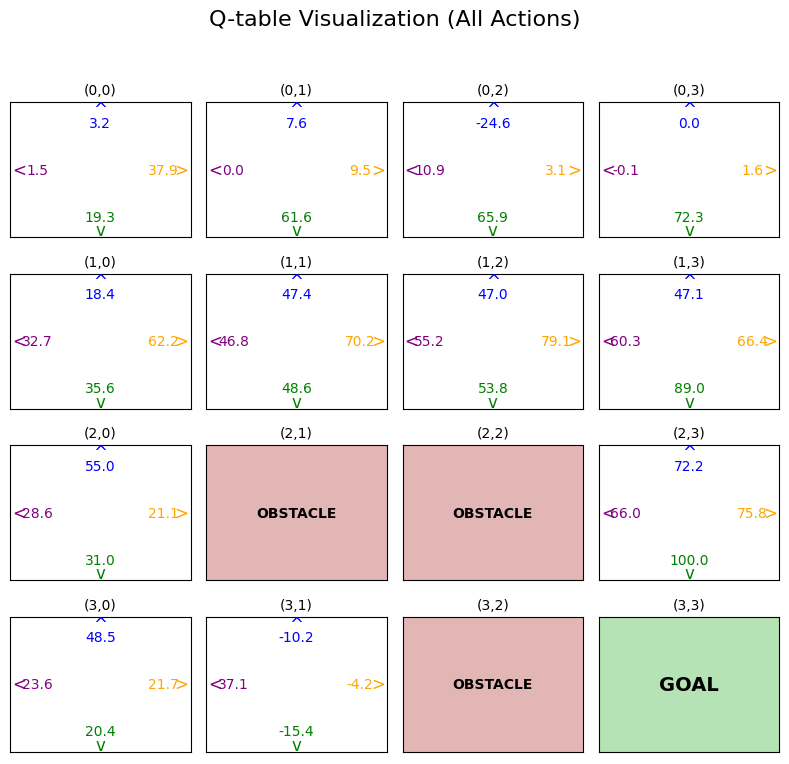

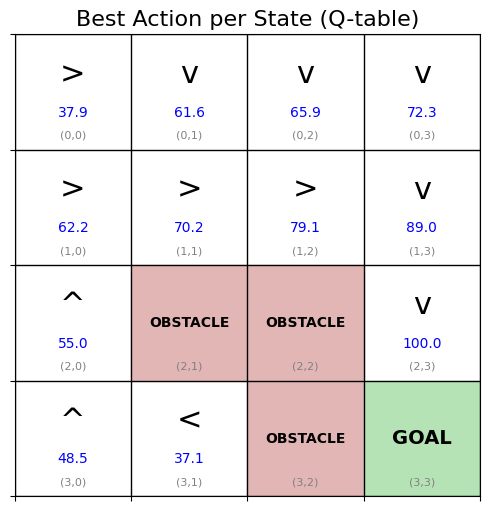

In [94]:
# Visualize the Q-table as a grid
visualize_q_table_as_grid(q_table)

# Visualize the best actions and their Q-values in a grid
visualize_best_actions_grid(q_table)